## import

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import os, sys
import cgi

import numpy as np
import astropy.io.fits as pyfits
#from mxtimetool import *
import datetime

from string import Template
import pandas as pd
import dateutil.parser

import matplotlib
#matplotlib.use("Agg")
import matplotlib.pyplot as plt
plt.ion()
import argparse

import matplotlib.dates as mdates
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.colors import LogNorm

#import cStringIO
import random
import base64
import astropy.stats.bayesian_blocks as bayesian_blocks

import os
from pylab import rcParams

## function definitions

In [86]:

def GetReinEdgebs_regular(LCDATA, MJDSTART, MJDSTOP,p0):
    return np.arange(MJDSTART, MJDSTOP+p0, p0)
    #return np.searchsorted( LCDATA["BINCENTER"], edges)


def GetRebinEdges_bayes(LCDATA, p0):
    return bayesian_blocks(LCDATA["BINCENTER"], LCDATA["RATE"], sigma=LCDATA["ERROR"], fitness='measures', p0=p0)


def GetBinEdges_gaps(LCDATA, p0):
    TIME=LCDATA["BINCENTER"]
    TIME=TIME[np.argsort(TIME)]
    gap_bincenters=[]
    gap_bincenters.append(TIME[0]+1e-4)
    for i in range(len(TIME)-1):
      if TIME[i+1]-TIME[i]>=p0:
        gap_bincenters.append(TIME[i]+3e-3)
        gap_bincenters.append(TIME[i+1]-3e-3)
    gap_bincenters.append(TIME[-1]+1e-4)
    return np.array(gap_bincenters)


def RebinData(LCDATA, binedges):
    binedges=binedges[np.argsort(binedges)]
    idx= np.searchsorted( LCDATA["BINCENTER"], binedges)
    idx2=np.vstack((idx[:-1],idx[1:])).T
    # [x,y,x_low,x_high,y_low,y_high]
    dt=np.dtype([('X','<f8'),('Y','<f8'),('EX','<f8'),('EY','<f8')])
    BLC=np.zeros(0, dtype=dt)
    for s0, s1 in idx2:
      if s0==s1:
        continue
      #print s0, s1
      TMP=np.zeros(1, dtype=dt)
      LCDATA_CUT=LCDATA[s0:s1]
      x=(LCDATA_CUT["START"][0]+LCDATA_CUT["STOP"][-1])*0.50
      ex=( LCDATA_CUT["STOP"][-1]-LCDATA_CUT["START"][0] )*0.50
      y=np.average(LCDATA_CUT["RATE"] )
      ey=np.sqrt(np.sum(LCDATA_CUT["ERROR"]*LCDATA_CUT["ERROR"]))/len(LCDATA_CUT["ERROR"])
      TMP['X']=x
      TMP['Y']=y
      TMP['EX']=ex
      TMP['EY']=ey
      BLC=np.hstack([BLC, TMP])
      #
    COL_BINC = pyfits.Column(name='BINCENTER', format='1D', array= BLC["X"] )
    COL_START = pyfits.Column(name='START', format='1D', array= BLC["X"] -BLC["EX"]  )
    COL_STOP = pyfits.Column(name='STOP', format='1D', array= BLC["X"] +BLC["EX"] )
    COL_RATE = pyfits.Column(name='RATE', format='1D', array= BLC["Y"]   )
    COL_ERROR = pyfits.Column(name='ERROR', format='1D', array= BLC["EY"]  )
    cols = pyfits.ColDefs([COL_BINC , COL_START, COL_STOP, COL_RATE, COL_ERROR] )
    tbhdu0=pyfits.TableHDU.from_columns( cols)
    return tbhdu0.data


def BATORB2GSC(BATDATA):
    MJD=np.zeros(len(BATDATA))
    for i in range(len(BATDATA)):
      MJD[i]=swift2mjd(BATDATA["TIME"][i])
    COL_BINC = pyfits.Column(name='BINCENTER', format='1D', array=MJD)
    COL_START = pyfits.Column(name='START', format='1D',array=MJD )
    COL_STOP = pyfits.Column(name='STOP', format='1D', array=MJD)
    COL_RATE = pyfits.Column(name='RATE', format='1D', array=BATDATA["RATE"] )
    COL_ERROR = pyfits.Column(name='ERROR', format='1D', array=BATDATA["ERROR"])
    cols = pyfits.ColDefs([COL_BINC , COL_START, COL_STOP, COL_RATE, COL_ERROR] )
    tbhdu0=pyfits.TableHDU.from_columns( cols, nrows=len(BATDATA))
    return tbhdu0.data


def split_binedges(binedges, p0):
  binedges_add=[]
  for i in range(len(binedges)-1):
    if (binedges[i+1]-binedges[i])>p0:
      binedges_add.append( (binedges[i+1]+binedges[i])*0.5 )
  binedges=np.hstack([binedges, np.array(binedges_add)])
  return binedges[np.argsort(binedges)]


## variable definitions

In [70]:
infname = "GTMus_8years_1orb_gsc.flc.gz"
outfname = "aaa.txt"
figname = "figname_test"

## Execution & Plot

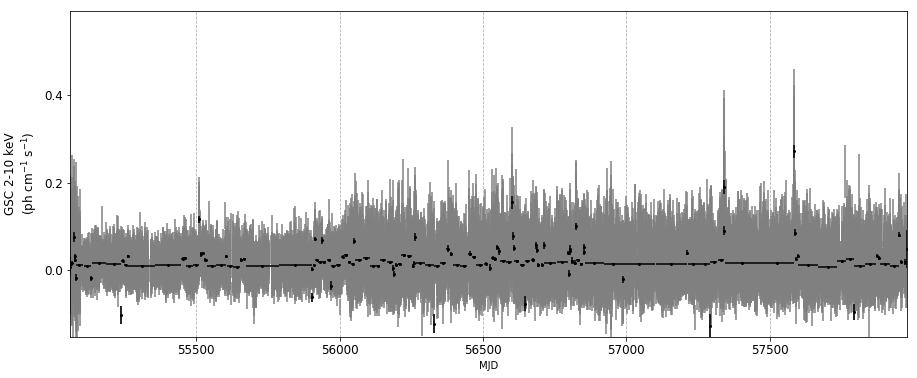

In [87]:

if __name__ == '__main__':
    """
    ap = argparse.ArgumentParser(description='a')
    #ap.add_argument('--infname', help='input file name', required=True)
    #ap.add_argument('--outfname', help='output file name', required=False)
    args = ap.parse_args()
    if args.outfname=="":
      outfname=os.path.basename(args.infname).split(".")[0]+"_rebin.txt"
    else:
      outfname=args.outfname
    """

    #gscf=pyfits.open(args.infname)
    gscf=pyfits.open(infname)
    gsclo=gscf["SCANLC0"].data
    gschi=gscf["SCANLC1"].data
    gsclo=gsclo[np.argsort(gsclo["BINCENTER"])]
    gschi=gschi[np.argsort(gschi["BINCENTER"])]

    fs = 12.
    p0_gap = 10
    p0_bayes = 0.1
    
    fig = plt.figure(0, (15,6))
    ax0 = plt.subplot(111)
    fig.patch.set_facecolor('white')
    fig.patch.set_alpha(1.0)
    plt.xlabel("MJD")
    plt.ylabel("GSC 2-10 keV\n(photon cm$^{-1}$ s$^{-1}$)", fontsize=fs)
    plt.xticks(fontsize=fs)
    plt.xlim(gsclo["BINCENTER"][0],gsclo["BINCENTER"][-1])
    ymin=np.min( [-0.05, np.min( gsclo["RATE"])*1.2 ])
    ymax=np.max( gsclo["RATE"])*1.5
    plt.ylim(ymin, ymax )
    plt.errorbar( gsclo["BINCENTER"], gsclo["RATE"],
      xerr=gsclo["STOP"]-gsclo["START"], yerr=gsclo["ERROR"], capsize=0, color="gray",fmt="none",alpha=1 )
    binedges_bayes=GetRebinEdges_bayes( gsclo, p0_bayes)
    binedges_gaps=GetBinEdges_gaps( gsclo, p0_gap )
    binedges=split_binedges(np.hstack([binedges_bayes,binedges_gaps]), 5.)
    gsclo_rebin=RebinData(gsclo, binedges)
    plt.errorbar( gsclo_rebin["BINCENTER"], gsclo_rebin["RATE"],
      xerr=0.5*(gsclo_rebin["STOP"]-gsclo_rebin["START"]), yerr=gsclo_rebin["ERROR"], capsize=0, color="black" ,fmt=",", markersize=2, marker="o")
    ax0.yaxis.set_major_locator(plt.MaxNLocator(4, prune='upper'))
    plt.yticks(fontsize=fs)
    #ax0.set_xticks([-1,0.,1,2])
    #ax0.set_xticks(np.arange(-1,2,0.1), minor=True)
    ax0.grid(axis="x", which="major", linestyle="--")
    ax0.grid(axis="x", which="minor", alpha=0.5, linestyle=":")
    #plt.figure(figsize=(40,10),dpi=400)

## Figures & Text save

In [88]:
    # TIME TIME_WIDTH RATE_ERR
    lc=np.array([gsclo_rebin["BINCENTER"],(gsclo_rebin["STOP"]-gsclo_rebin["START"])/2, gsclo_rebin["RATE"],gsclo_rebin["ERROR"]]).T
    plt.savefig("figure.png")
    np.savetxt(outfname,lc,fmt=["%.8f","%.8f","%.5f","%.5f"])

<Figure size 2160x720 with 0 Axes>

In [61]:
f = open('aaa.txt')
print(f.read())

55058.68763527 0.00000000 0.00772 0.02163
55062.08572625 3.33457146 0.01423 0.00245
55068.22248844 2.78748451 0.01700 0.00290
55073.69173184 0.39505387 0.07526 0.01146
55075.42049898 1.27042160 0.03153 0.00514
55078.00988480 1.27032768 0.02385 0.00517
55079.63701213 0.34191466 -0.01751 0.00800
55092.64646886 12.65270155 0.01221 0.00169
55119.25365991 12.17811358 0.01048 0.00137
55133.14447802 1.52239380 -0.01862 0.00537
55160.31221221 25.58191849 0.01607 0.00093
55211.62504594 25.60425917 0.01371 0.00089
55237.23687871 0.00000000 -0.10249 0.02050
55242.74102798 5.46926317 0.02205 0.00262
55254.33511818 5.68047205 0.01249 0.00156
55261.79325263 1.71420572 0.03202 0.00350
55309.72621765 46.15526115 0.01030 0.00073
55402.10964872 46.16456802 0.01106 0.00072
55452.40681530 4.06901164 0.02614 0.00393
55461.08374055 3.97216414 0.02685 0.00257
55476.18171344 11.06224418 0.00911 0.00149
55498.37165718 11.06411217 0.01252 0.00133
55510.51634538 1.01700834 0.11592 0.00703
55515.72747135 3.558554